In [1]:
import sys
sys.path.insert(1, 'C:/Users/raena/Documents/Imperial College London/msc_thesis/code/functions_and_classes')

from dataRead import *
from glob import glob
import pandas as pd
import numpy as np

## Check EQW over whole period

In [2]:
# Get DJI Index weights data per quarter

DJI_weights_paths = glob('../../data/dataBBG/DJI_index_weights/DJI_*.pickle')
DJI_weights_per_quarter = {}
for path in DJI_weights_paths:
    date = path.split('.')[-2].split('_')[-1]
    DJI_weights_per_quarter[date] = pd.read_pickle(path)

# Import price and volume data for each stock in the DJI Index
DJI_PX_LAST_paths = glob('../../data/dataBBG/DJI_stock_PX_LAST/* Equity.pickle')
DJI_PX_VOLUME_paths = glob('../../data/dataBBG/DJI_stock_PX_VOLUME/* Equity.pickle')

DJI_price_data = {}
DJI_volume_data = {}

for path in DJI_PX_LAST_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    # if ticker == '3277Q UN': # JP Morgan
    #     path = '../../data/dataBBG/DJI_stock_PX_LAST/JPM UN Equity.pickle'
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    DJI_price_data[ticker] = df

for path in DJI_PX_VOLUME_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    df = pd.read_pickle(path).set_index('date')
    df.index = pd.to_datetime(df.index)
    # df.index = pd.to_datetime(df.index)
    DJI_volume_data[ticker] = df

trading_days = pd.to_datetime(list(DJI_price_data['AAPL'].index))

# Heatmap


In [4]:
AUM = 1e6
qDates = list(DJI_weights_per_quarter.keys())
n_q = len(qDates)
results = {}

k = -1
dat = qDates[k-4]
datend = str(int(qDates[k]) - 1)
# dat = '20211231'
# datend = '20220214'
weights_data = DJI_weights_per_quarter[dat]
members = weights_data.sort_values(by = 'Weight', ascending = False)['INDX_MWEIGHT_HIST'].iloc[0:10]
# wgt = weights_data.set_index('INDX_MWEIGHT_HIST')['Weight']
prices = pd.DataFrame({ticker: DJI_price_data[ticker]['PX_LAST'] for ticker in DJI_price_data.keys()})
volumes = pd.DataFrame({ticker: DJI_volume_data[ticker]['PX_VOLUME'] for ticker in DJI_price_data.keys()})
tempR = np.log(prices.loc[str(dat):str(datend),members]).diff(1).iloc[1:] # log returns
tempV = volumes.loc[str(dat):str(datend),members].iloc[1:] 
tempV = np.log(tempV)
tempV = (tempV - tempV.mean(axis=0))/tempV.std(axis = 0, ddof=1)
print(tempR.shape)
print(tempR.index[0])
print(tempR.index[-1])

(251, 10)
2022-01-03 00:00:00
2022-12-30 00:00:00


In [62]:
from matplotlib import pyplot as plt
import seaborn as sns

def corr_heatmap(heatmap1, 
                axislabels, 
                ax,
                title = "Sample Historical Correlation of Daily Returns",
                vmin = -1,
                vmax = 1,
                cmap = 'PiYG'):
    sns.heatmap(heatmap1, cmap = cmap, vmin = vmin, vmax = vmax, cbar=False, ax = ax)
    ax.set_xticks(np.arange(heatmap1.shape[0]) + 0.5, labels=axislabels,
                     rotation=45, ha="right", va="center", rotation_mode="anchor")
    ax.set_yticks(np.arange(heatmap1.shape[0]) + 0.5, labels=axislabels,
                     rotation=0, ha="right", va="center", rotation_mode="anchor")
    ax.set_title(title, fontsize = 14)
    # fig.tight_layout()
    return fig, ax

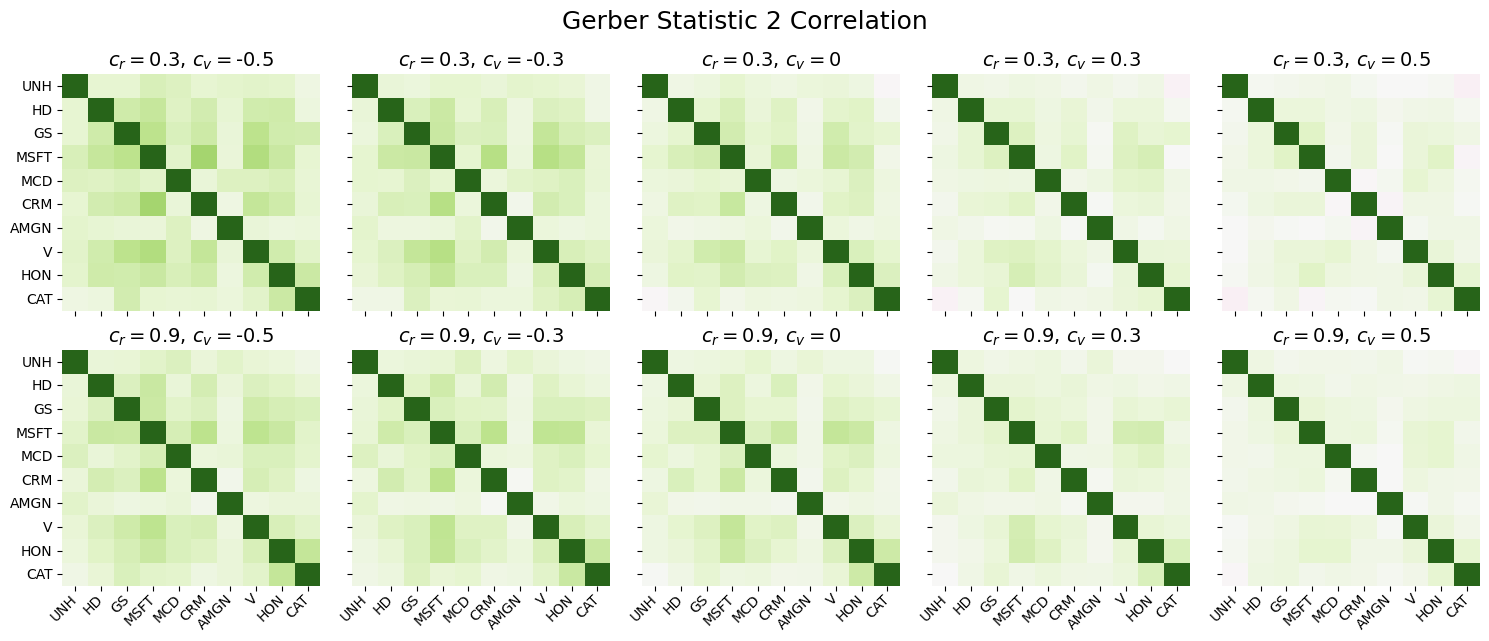

In [67]:
from covarianceMatrixVolume import *
from thresholdVectors import *
cRList = [0.3,0.9]
cVList = [-0.5, -0.3, 0, 0.3, 0.5]

covMatInst = CovarianceMatrixVolume(returnsMatrix = tempR, volumeMatrix = tempV)

fpFig = '../../code/figures'
fig, ax = plt.subplots(2, 5, figsize=(15,6.5), sharex = True, sharey = True)
# ax = ax.reshape(-1)
for j, cR in enumerate(cRList):
    for i, cV in enumerate(cVList):
        rThreshold = ThresholdVectors(tempR).standard_deviation(c = cR)
        vThreshold = ThresholdVectors(tempV).standard_deviation(c = cV)
        GS2 = covMatInst.GerberMatrix2(rThreshold, vThreshold, method = 'quick')[0]
        figHIS, axHIS = corr_heatmap(GS2, axislabels = members, 
                                    title = r'$c_r = $' + str(cR) + r', $c_v = $' + str(cV), 
                                    ax = ax[j,i])
fig.suptitle('Gerber Statistic 2 Correlation', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fpFig}/correlation_heatmap_volume_thresholds.pdf', bbox_inches='tight')


In [6]:
DJI_div_paths = glob('../../data/dataBBG/DJI_stock_DIVIDENDS/* Equity.pickle')

dividend_data = {}

for path in DJI_div_paths:
    ticker = (' ').join(path.split('.')[-2].split('\\')[-1].split(' ')[0:1])
    df = pd.read_pickle(path)
    # df.index = pd.to_datetime(df.index)
    dividend_data[ticker] = df

In [128]:
dividend_data['JPM']

,decDate,exDDate,recDate,payDate,divAmnt,divFreq,divType
0,2022-09-20,2022-10-05,2022-10-06,2022-10-31,1.000000,Quarter,Regular Cash
1,2022-05-16,2022-07-05,2022-07-06,2022-07-31,1.000000,Quarter,Regular Cash
2,2022-03-15,2022-04-05,2022-04-06,2022-04-30,1.000000,Quarter,Regular Cash
3,2021-12-14,2022-01-05,2022-01-06,2022-01-31,1.000000,Quarter,Regular Cash
4,2021-09-21,2021-10-05,2021-10-06,2021-10-31,1.000000,Quarter,Regular Cash
...,...,...,...,...,...,...,...
180,1978-02-10,1978-03-09,1978-03-15,1978-04-01,0.111111,Quarter,Regular Cash
181,1977-11-11,1977-12-09,1977-12-15,1978-01-01,0.111111,Quarter,Regular Cash
182,1977-08-11,1977-09-09,1977-09-15,1977-10-01,0.111111,Quarter,Regular Cash
183,1977-05-13,1977-06-09,1977-06-15,1977-07-01,0.111111,Quarter,Regular Cash


<Axes: xlabel='recDate'>

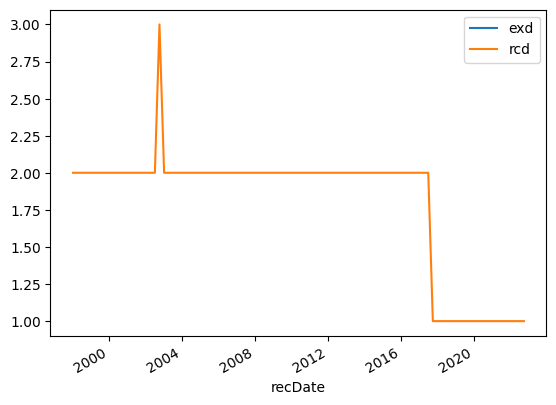

In [127]:
stock = 'JPM'
df = dividend_data[stock]
df = df[df['divType'] == 'Regular Cash']
exd = pd.to_datetime(df['exDDate'])
exd = exd[exd >= '1997-12-31']
rcd = pd.to_datetime(df['recDate'])
rcd = rcd[rcd >= '1997-12-31']
eS = pd.Series([np.where(trading_days >= i)[0][0] for i in exd], index = rcd)
rS = pd.Series([np.where(trading_days >= i)[0][0] for i in rcd], index = rcd)
pd.DataFrame({'exd' : eS, 'rcd' : rS}).diff(1, axis = 1).plot()